In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
train_df = pd.read_csv('/content/twitter_training.csv')
train_df.rename(columns={'2401' : 'Index' , 'Borderlands': 'Entity' , 'Positive' : 'Sentiments'
                   , "im getting on borderlands and i will murder you all ,": 'Text'}, inplace=True)
train_df.head()

,Index,Entity,Sentiments,Text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [ ]:
# data validation
valid_df = pd.read_csv('/content/twitter_validation.csv')
valid_df.rename(columns={'3364' : 'Index' , 'Facebook': 'Entity' , 'Irrelevant' : 'Sentiments'
                   , "I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣": 'Text'}, inplace=True)
valid_df.head()

,Index,Entity,Sentiments,Text
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [ ]:
train_df.shape

(74681, 4)

In [ ]:
train_df.isna().sum()

,0
Index,0
Entity,0
Sentiments,0
Text,686


In [ ]:
train_df.duplicated().sum()

2700

In [ ]:
train_df.dropna(inplace=True)
train_df.drop_duplicates(inplace=True)
train_df.shape

(71655, 4)

In [ ]:
def bersihkan_teks(teks):
    # Mengubah semua teks menjadi huruf kecil
    teks = teks.lower()

    # Menghapus link/URL
    teks = re.sub(r'http\S+|www\S+|https\S+', ' ', teks, flags=re.MULTILINE)

    # Menghapus emoji dan karakter non-ASCII
    teks = re.sub(r'[^\x00-\x7F]+', ' ', teks)

    # Menghapus tanda baca dan simbol lainnya
    teks = re.sub(r'[^a-zA-Z0-9\s]', ' ', teks)

    # Menghapus angka (opsional, jika tidak ingin menghapus angka, hapus baris ini)
    teks = re.sub(r'\d+', ' ', teks)

    # Menghapus spasi ganda yang mungkin terbentuk
    teks = re.sub(r'\s+', ' ', teks).strip()

    # Normalize Words
    teks = re.sub(r"won\'t", "would not", teks)
    teks = re.sub(r"im", "i am", teks)
    teks = re.sub(r"Im", "i am", teks)
    teks = re.sub(r"can\'t", "can not", teks)
    teks = re.sub(r"don\'t", "do not", teks)
    teks = re.sub(r"shouldn\'t", "should not", teks)
    teks = re.sub(r"needn\'t", "need not", teks)
    teks = re.sub(r"hasn\'t", "has not", teks)
    teks = re.sub(r"haven\'t", "have not", teks)
    teks = re.sub(r"weren\'t", "were not", teks)
    teks = re.sub(r"mightn\'t", "might not", teks)
    teks = re.sub(r"didn\'t", "did not", teks)
    teks = re.sub(r"n\'t", " not", teks)
    teks = re.sub(r"\'re", " are", teks)
    teks = re.sub(r"\'s", " is", teks)
    teks = re.sub(r"\'d", " would", teks)
    teks = re.sub(r"\'ll", " will", teks)
    teks = re.sub(r"\'t", " not", teks)
    teks = re.sub(r"\'ve", " have", teks)
    teks = re.sub(r"\'m", " am", teks)
    teks = re.sub(r'unk' , ' ' , teks)
    return teks
train_df['Text'] = train_df['Text'].apply(bersihkan_teks)
valid_df['Text'] = valid_df['Text'].apply(bersihkan_teks)

In [ ]:
train_df.sample(5)

,Index,Entity,Sentiments,Text
40824,1406,Battlefield,Positive,atviassist keep getting error dev on warzone c...
29865,735,ApexLegends,Neutral,this area is the entire latest hiding safe spo...
26410,936,AssassinsCreed,Positive,i fe in love with this city after playing apos...
1940,2740,Borderlands,Negative,full offense if you bought borderlands fuck yo...
2857,1696,CallOfDutyBlackopsColdWar,Irrelevant,yaraskygaming jackgs of my favorite young play...


In [ ]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# # Daftar stop words tambahan
# more_stop_words = ['im']
# stop_words.update(more_stop_words)
def preprocess_text(text):
    words = text.split()
    processed_words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(processed_words)

# Terapkan preprocessing pada semua teks
train_df['Text'] = train_df['Text'].apply(preprocess_text)
valid_df['Text'] = valid_df['Text'].apply(preprocess_text)

In [ ]:
train_df.sample(5)

,Index,Entity,Sentiments,Text
72063,11145,TomClancysGhostRecon,Neutral,gamologyu everi gamolog magic truli born boing...
56803,11346,TomClancysRainbowSix,Negative,good feel
68380,3709,Cyberpunk2077,Positive,play x box awesom
56391,11277,TomClancysRainbowSix,Irrelevant,ok block young man fault new level
36437,8253,Microsoft,Neutral,entrepreneur learn microsoft excel class may s...


In [ ]:
train_df =train_df[['Text','Sentiments']]
train_df.sample(5)

,Text,Sentiments
37097,,Neutral
32208,leagu legend duoq rank jungler mid twitch tv s...,Neutral
32406,still want know riot rank tft mission leagu le...,Negative
38033,ok playhearthston ash outland prologu made fee...,Positive
72319,ti ame despit fact current million peopl live ...,Neutral


In [ ]:
valid_df =valid_df[['Text','Sentiments']]
valid_df.sample(5)

,Text,Sentiments
328,ghostrecon ghostreconbreakpoint took termin pi...,Negative
260,playapex problem buy battlepass new patch,Negative
996,today suck ti ame drink wine n play borderland...,Positive
110,joe buck excit hearthston,Neutral
464,xsxfridgesweep power fridg world beast,Irrelevant


In [ ]:
train_df['Sentiments'] = train_df['Sentiments'].map({'Positive' : 1 ,  'Negative' : 0 ,'Neutral':2 , 'Irrelevant' : 2 })
valid_df['Sentiments'] = valid_df['Sentiments'].map({'Positive' : 1 ,  'Negative' : 0 ,'Neutral':2 , 'Irrelevant' : 2 })

In [ ]:
train_texts = train_df['Text'].values
train_labels = train_df['Sentiments'].values

val_texts = valid_df['Text'].values
val_labels = valid_df['Sentiments'].values

In [ ]:
tokenizer = Tokenizer(num_words=10000)  # Sesuaikan jumlah kata maksimum
tokenizer.fit_on_texts(train_texts)  # Tokenizer hanya di-fit pada data training

train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)

max_sequence_length = 100
X = pad_sequences(train_sequences, maxlen=max_sequence_length)
X_val = pad_sequences(val_sequences, maxlen=max_sequence_length)

In [ ]:
import pickle

# Simpan tokenizer ke file
with open('tokenizer2.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)
print("Tokenizer telah disimpan.")

Tokenizer telah disimpan.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, train_labels, test_size=0.1, random_state=42)

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

train_labels = np.array(y_train)
test_labels = np.array(y_test)
val_labels = np.array(val_labels)

In [ ]:
model = models.Sequential([
    Embedding(input_dim=10000, output_dim=100, input_length=max_sequence_length),
    layers.LSTM(64, return_sequences=True),
    # layers.Dropout(0.2),
    layers.LSTM(32),
    layers.Dropout(0.2),
    # Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Menggunakan sparse loss
    metrics=['accuracy']
)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 6. Training Model
history = model.fit(
    X_train, train_labels,
    validation_data=(X_val, val_labels),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 141s 70ms/step - accuracy: 0.9494 - loss: 0.1256 - val_accuracy: 0.9309 - val_loss: 0.3500
Epoch 2/10
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 142s 70ms/step - accuracy: 0.9546 - loss: 0.1087 - val_accuracy: 0.9329 - val_loss: 0.3845
Epoch 3/10
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 143s 70ms/step - accuracy: 0.9575 - loss: 0.1011 - val_accuracy: 0.9329 - val_loss: 0.4127
Epoch 4/10
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 200s 70ms/step - accuracy: 0.9604 - loss: 0.0922 - val_accuracy: 0.9289 - val_loss: 0.4330
Epoch 5/10
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 143s 70ms/step - accuracy: 0.9616 - loss: 0.0900 - val_accuracy: 0.9279 - val_loss: 0.4615
Epoch 6/10
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 142s 70ms/step - accuracy: 0.9649 - loss: 0.0800 - val_accuracy: 0.9329 - val_loss: 0.4644
Epoch 7/10
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 143s 71ms/step - accuracy: 0.9646 - loss: 0.0798 - val_accuracy: 0.9399 - val_loss: 0.3967
Epoch 8/10
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 141s 70ms/step - accuracy: 

In [ ]:
model.save('model.h5')

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test,test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9013 - loss: 0.4720
Test Accuracy: 89.28%


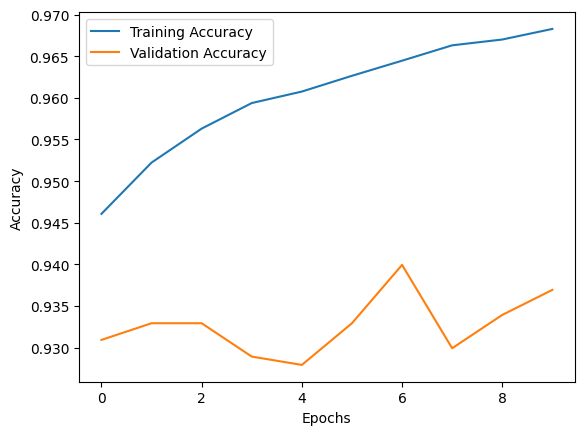

In [ ]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

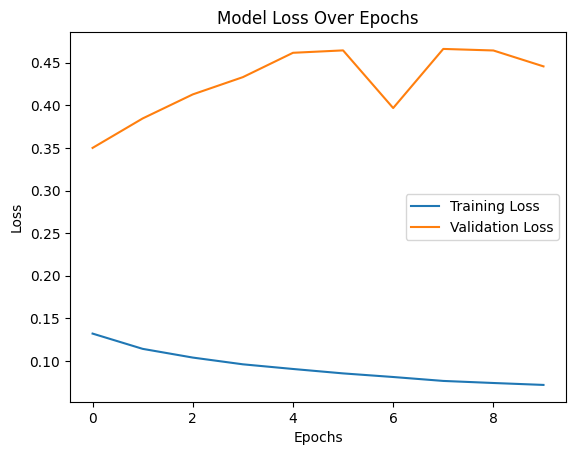

In [ ]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Over Epochs')
plt.show()

224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step


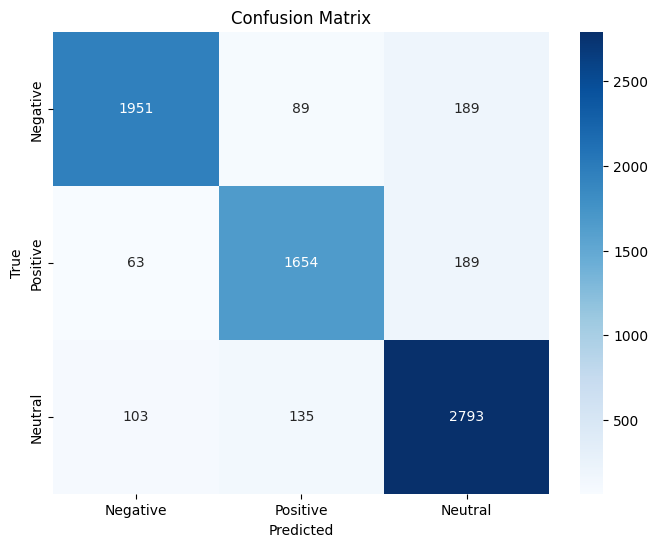

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
y_pred_probs = model.predict(X_test)
# If `y_pred_probs` is a 1D array, it directly contains the predicted class indices.
if len(y_pred_probs.shape) == 1:
    y_pred_labels = y_pred_probs
else:
    y_pred_labels = np.argmax(y_pred_probs, axis=1)

# If `test_labels` is a 1D array, it directly contains the true class indices.
if len(test_labels.shape) == 1:
    y_true_labels = test_labels
else:
    y_true_labels = np.argmax(test_labels, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive', 'Neutral'],
            yticklabels=['Negative', 'Positive', 'Neutral'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()